In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid, draw_bounding_boxes
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

torch.manual_seed(0)

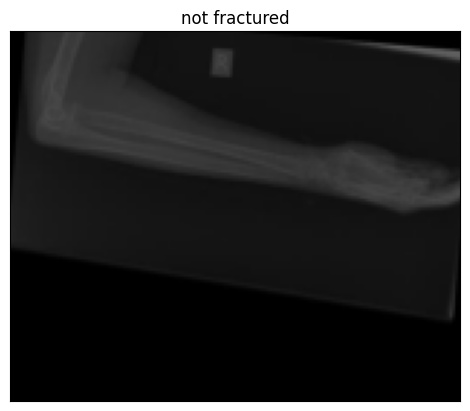

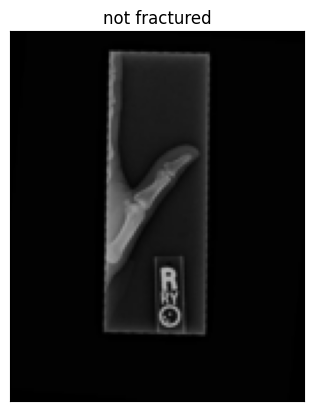

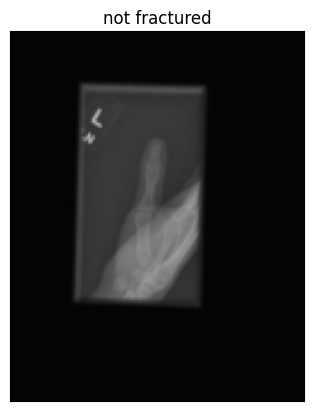

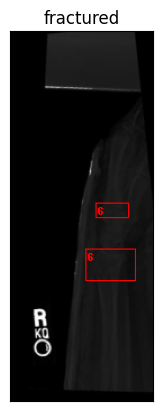

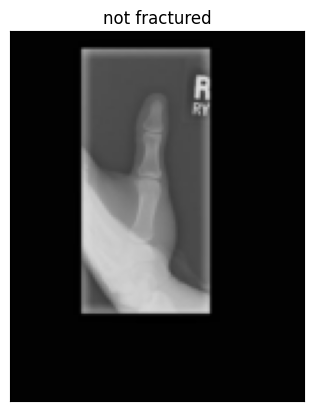

In [3]:
# Define directories (using variables from notebook (1))
Test = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/test/'
Train = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/train/'
Valid = '/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset/valid/'

# Define constants
load_shape = 128

# Define transforms
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

# Define function to visualize images with labels
def show_with_labels(imgs, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        if labels:
            label = "fractured" if labels[i] else "not fractured"
        else:
            label = "not fractured"  # Default label if no bounding boxes
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set_title(label)  # Set title as "fractured" or "not fractured"
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Custom dataset class to load images and bounding box annotations
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/images/*.jpg'))
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

# Load the image dataset using the defined directory variables
dataset = ImageDataset("/home/elt/rw372/notebook/COMP8260 - A.I Systems/Project/Dataset", transform=transform)

# Define the number of random images to display
num_random_images = 5

# Randomly select indices of images
random_indices = random.sample(range(len(dataset)), num_random_images)

# Visualize random sample images with labels
for index in random_indices:
    img = transforms.functional.convert_image_dtype(dataset.get_image(index), dtype=torch.uint8)
    labels = dataset.get_labels(index)
    # Check if bounding boxes exist
    if labels:
        # Draw bounding boxes
        drawn_boxes = draw_bounding_boxes(img, dataset.get_boxes(index), colors="red", labels=[str(x) for x in labels])
        show_with_labels(drawn_boxes, labels)
    else:
        # No bounding boxes, print "not fractured"
        show_with_labels(img, labels)